In [2]:
import pandas as pd
import csv
import os
import pandas as pd
import numpy as np
import math
import os,sys
import pandas as pd
import pickle
import matplotlib.pyplot as plt



In [88]:
green_2015_09 = pd.read_pickle("./green_2015_09 .pkl")

# Building a model for predicting tip_percent 

## Derive tip_percent feature

In [89]:
#derive a tip percent feature
green_2015_09['tip_percentage'] = green_2015_09['Tip_amount']/green_2015_09['Total_amount']

In [90]:
#Since inital charge of a cap is $2.5, I will only use the data whose total charge is greater than 2.5.
# https://www1.nyc.gov/site/tlc/passengers/taxi-fare.page
green_2015_09 = green_2015_09[green_2015_09['Total_amount'] >= 2.5]

In [91]:
green_2015_09.shape

(1487767, 23)

## Data Cleansing 

In [92]:
#A function return a list of column names of numerical features  and categorical features
def get_cate_numeric_feature(input):
    names = input.columns;
    cate_data = []
    numeric_data = []
    for cur_name in names:
        if input[cur_name].dtypes == 'O':
            cate_data.append(cur_name)
        else:
            numeric_data.append(cur_name)
    return [cate_data, numeric_data]
    

In [93]:
output = get_cate_numeric_feature(green_2015_09)
cate_data = output[0]
numeric_data = output[1]

In [94]:
green_2015_09.shape

(1487767, 23)

In [95]:
numeric_data.remove('VendorID')
numeric_data.remove('RateCodeID')
numeric_data.remove('Ehail_fee')

In [96]:
cate_data.append('RateCodeID')
cate_data.append('VendorID')

In [12]:
numeric_data

['Pickup_longitude',
 'Pickup_latitude',
 'Dropoff_longitude',
 'Dropoff_latitude',
 'Passenger_count',
 'Trip_distance',
 'Fare_amount',
 'Extra',
 'MTA_tax',
 'Tip_amount',
 'Tolls_amount',
 'improvement_surcharge',
 'Total_amount',
 'Payment_type',
 'Trip_type ',
 'tip_percentage']

### Distribution of Categorical features 

In [13]:
cate_data

['lpep_pickup_datetime',
 'Lpep_dropoff_datetime',
 'Store_and_fwd_flag',
 'tpep_pickup_hour',
 'RateCodeID',
 'VendorID']

In [14]:
#VendorID_info is a provider info
VendorID_info = green_2015_09[['VendorID','Pickup_longitude']].groupby('VendorID').agg('count').reset_index().rename(columns = {'Pickup_longitude':'Counts'})
VendorID_info

,VendorID,Counts
0,1,322149
1,2,1165618


Seems like there is no huge difference the distribtuions of tip_percentage when VendorID = 1,2.

In [211]:
green_2015_09[green_2015_09['VendorID']==1]['tip_percentage'].describe()

count    322149.000000
mean          0.068038
std           0.091998
min           0.000000
25%           0.000000
50%           0.000000
75%           0.165877
max           1.000000
Name: tip_percentage, dtype: float64

In [212]:
green_2015_09[green_2015_09['VendorID']==2]['tip_percentage'].describe()

count    1.165618e+06
mean     6.627829e-02
std      8.783808e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      9.933775e-01
Name: tip_percentage, dtype: float64

In [15]:
RatecodeID_info = green_2015_09[['RateCodeID','VendorID']].groupby('RateCodeID').agg('count').reset_index().rename(columns = {'VendorID':'Counts'})
RatecodeID_info

,RateCodeID,Counts
0,1,1451627
1,2,4299
2,3,1091
3,4,912
4,5,29802
5,6,32
6,99,4


In [16]:
payment_type_info = green_2015_09[['Payment_type','VendorID']].groupby('Payment_type').agg('count').reset_index().rename(columns = {'VendorID':'Counts'})
payment_type_info

,Payment_type,Counts
0,1,700934
1,2,779391
2,3,3922
3,4,3448
4,5,72


We can see that most passengers didn't pay tips when their payment type = 2 (cash).

In [128]:
green_2015_09[green_2015_09['Payment_type']==1]['tip_percentage'].describe()

count    700934.000000
mean          0.141486
std           0.078316
min           0.000000
25%           0.107914
50%           0.166667
75%           0.166667
max           1.000000
Name: tip_percentage, dtype: float64

In [130]:
green_2015_09[green_2015_09['Payment_type']==2]['tip_percentage'].describe()

count    779391.000000
mean          0.000001
std           0.001117
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.972132
Name: tip_percentage, dtype: float64

In [17]:
store_and_fwd_flag_info = green_2015_09[['Store_and_fwd_flag','VendorID']].groupby('Store_and_fwd_flag').agg('count').reset_index().rename(columns = {'VendorID':'Counts'})
store_and_fwd_flag_info

,Store_and_fwd_flag,Counts
0,N,1479198
1,Y,8569


### Missing value imputations 

In current data, 2 features (Ehail_fee, Trip_type) have missing value.
1. Ehail_fee : 100 % of them are missing value
2. Trip_type : only 4 of 1487767 rows have missing value

So I will remove Ehail_fee and ignore 4 missing values of 1487767 rows in Trip_type

In [97]:
col_names = green_2015_09.columns
col_list = {}
for i in col_names:
    if (green_2015_09[i].isnull()).sum() > 0:
        col_list[i] = (green_2015_09[i].isnull()).sum() 
        
col_list

{'Ehail_fee': 1487767, 'Trip_type ': 4}

In [98]:
green_2015_09 = green_2015_09.drop(columns = ['Ehail_fee'])
green_2015_09 = green_2015_09[~green_2015_09[i].isnull()]

In [99]:
green_2015_09.shape

(1487767, 22)

### Date Data tranformation 

I tranformed pickup date feature to hour, day and weekdays and dropoff-date to drop-off hour. 

In [100]:
import datetime as dt
green_2015_09['lpep_pickup_dt'] = green_2015_09['lpep_pickup_datetime'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))
green_2015_09['Lpep_dropoff_dt'] = green_2015_09['Lpep_dropoff_datetime'].apply(lambda x: dt.datetime.strptime(x,"%Y-%m-%d %H:%M:%S"))

In [101]:
green_2015_09['lpep_pickup_hour'] = green_2015_09['lpep_pickup_dt'].apply(lambda x: x.hour)
green_2015_09['lpep_pickup_day'] = green_2015_09['lpep_pickup_dt'].apply(lambda x: x.day)
green_2015_09['lpep_pickup_weekday'] = green_2015_09['lpep_pickup_dt'].apply(lambda x: x.weekday())

In [102]:
green_2015_09['lpep_dropoff_hour'] = green_2015_09['Lpep_dropoff_dt'].apply(lambda x: x.hour)

In [103]:
green_2015_09['trip_times'] = (green_2015_09['Lpep_dropoff_dt'] - green_2015_09['lpep_pickup_dt']).apply(lambda x: x.total_seconds()) 

### Dummy variables  (Transform Categorical features to Numerical features

In [104]:
#Cate to dummy : RatecodeID, store_and_fwd_flag, Payment_type
#feature to drop : VendorID, tpep_pickup_datetime, tpep_dropoff_datetime, tpep_pickup_dt, tpep_dropoff_dt, tip_amount

column_to_drop = ['VendorID','lpep_pickup_datetime','Lpep_dropoff_datetime','lpep_pickup_dt','Lpep_dropoff_dt','Tip_amount','Total_amount']
updated_green = green_2015_09.drop(columns = column_to_drop)


In [105]:
#Create Dummy features
cate_list = ['RateCodeID', 'Store_and_fwd_flag', 'Payment_type']

for i in cate_list:
    dummies = pd.get_dummies(updated_green[i]).rename(columns=lambda x: i+'_' + str(x))
    updated_green = pd.concat([updated_green,dummies], axis=1)
    updated_green = updated_green.drop(columns = [i])

In [106]:
updated_green.columns

Index([u'Pickup_longitude', u'Pickup_latitude', u'Dropoff_longitude',
       u'Dropoff_latitude', u'Passenger_count', u'Trip_distance',
       u'Fare_amount', u'Extra', u'MTA_tax', u'Tolls_amount',
       u'improvement_surcharge', u'Trip_type ', u'tip_percentage',
       u'tpep_pickup_hour', u'lpep_pickup_hour', u'lpep_pickup_day',
       u'lpep_pickup_weekday', u'lpep_dropoff_hour', u'trip_times',
       u'RateCodeID_1', u'RateCodeID_2', u'RateCodeID_3', u'RateCodeID_4',
       u'RateCodeID_5', u'RateCodeID_6', u'RateCodeID_99',
       u'Store_and_fwd_flag_N', u'Store_and_fwd_flag_Y', u'Payment_type_1',
       u'Payment_type_2', u'Payment_type_3', u'Payment_type_4',
       u'Payment_type_5'],
      dtype='object')

## Target Feature

In [107]:
updated_green['tip_percentage'].describe()

count    1.487767e+06
mean     6.665932e-02
std      8.875835e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.666667e-01
max      1.000000e+00
Name: tip_percentage, dtype: float64

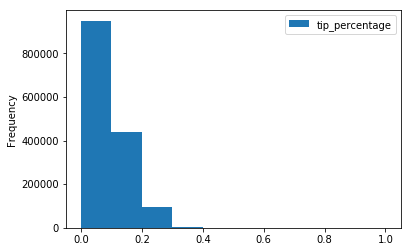

In [108]:
updated_green[['tip_percentage']].plot.hist()

We can see that almost 60% of target feature are 0.0% 

In [109]:
print "Number of no tips: " + str((updated_green['tip_percentage'] == 0).sum())
print "Number of tips: " + str((updated_green['tip_percentage'] > 0).sum())
print "Number of no tips %: " + str((updated_green['tip_percentage'] == 0).sum()/(updated_green.shape[0]*1.0))
print "Number of tips %: " + str((updated_green['tip_percentage'] > 0).sum()/(updated_green.shape[0]*1.0))


Number of no tips: 885046
Number of tips: 602721
Number of no tips %: 0.5948821287204247
Number of tips %: 0.4051178712795754


Let's look at the distribution of target feature with tip_percentage > 0 . 

In [110]:
updated_green[updated_green['tip_percentage'] > 0]['tip_percentage'].describe()

count    602721.000000
mean          0.164543
std           0.057795
min           0.000083
25%           0.161290
50%           0.166667
75%           0.166708
max           1.000000
Name: tip_percentage, dtype: float64

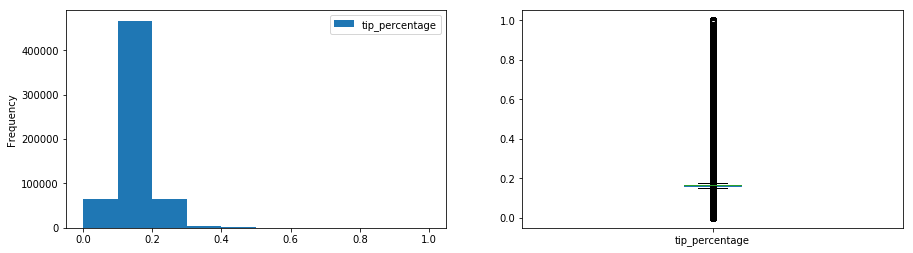

In [111]:
tip_percentage_info = updated_green[updated_green['tip_percentage'] > 0][['tip_percentage']]
fig,ax = plt.subplots(1,2,figsize = (15,4))

tip_percentage_info.plot.hist(ax=ax[0])
tip_percentage_info.plot.box(ax=ax[1])

In [112]:
tip_percentage = updated_green['tip_percentage']
updated_green = updated_green.drop(columns= 'tip_percentage')
updated_green = pd.concat([updated_green,tip_percentage], axis=1)

We can see that the target feature (tip percentages) is not linearly correlated with most of input features. So we can not use a linear regression model for this data. So **Random Forest Regression model** could be a good option. Additionally, we also can see that some highly correlated input features, but since  I am going to build a Random Forest model (a tree based model), I didn't delete them.  

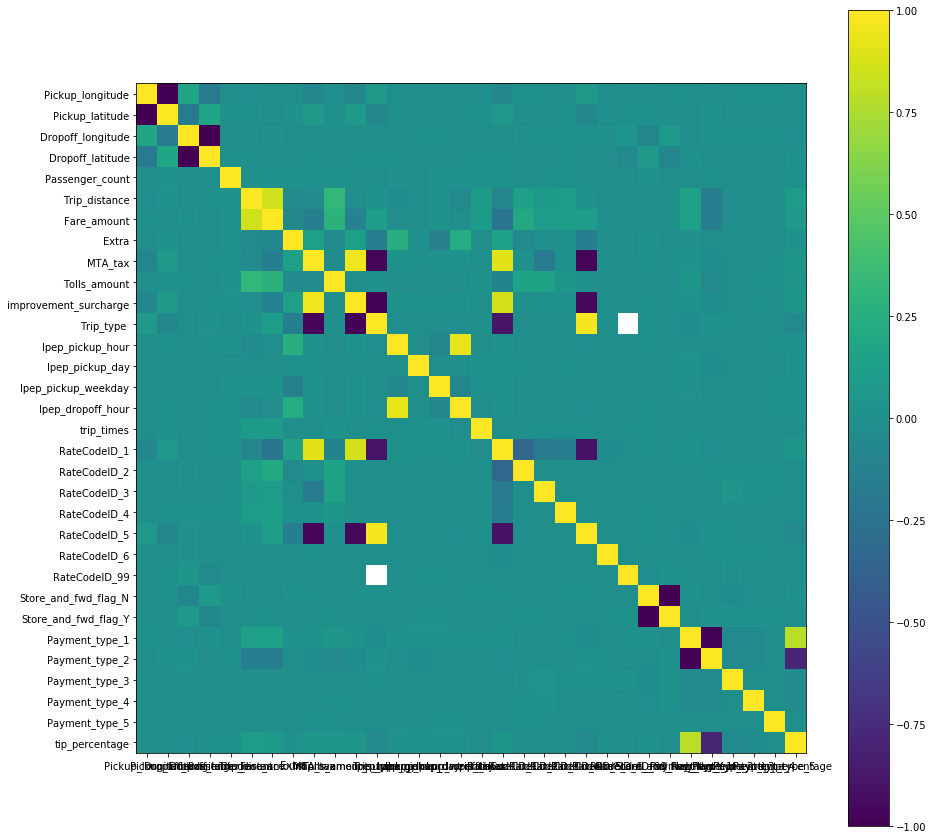

In [113]:
#updated_green_0 = updated_green[updated_green['tip_percentage'] > 0]
updated_green_0_corr = updated_green.corr()
updated_green_0_corr = updated_green_0_corr[~updated_green_0_corr['tip_percentage'].isnull()]
fig = plt.figure(1, figsize=(15,15) )
plt.imshow(updated_green_0_corr)
plt.xticks(range(len(updated_green_0_corr.columns)), updated_green_0_corr.columns);
plt.yticks(range(len(updated_green_0_corr.columns)), updated_green_0_corr.columns);
plt.colorbar()

### Lattitude and Longitude 

I explored pickup/drop-off-lattitude and longitude features. 
1. Pickup: Passengers took their taxis in Brooklyn, Queens and The Bronx but not in Manhattan  
2. Drop-off: They got off at Brooklyn, Queens and The Bronx and Manhattan 

In [114]:
#Remove the cases whose pick-up and drop-off locations are not in New York.

updated_green = updated_green[(updated_green['Pickup_latitude'] > 40.5774) & (updated_green['Pickup_latitude'] <= 40.9176)]
updated_green = updated_green[(updated_green['Pickup_longitude'] > -74.15) & (updated_green['Pickup_longitude'] <= -73.7004)]

updated_green = updated_green[(updated_green['Dropoff_latitude'] > 40.5774) & (updated_green['Dropoff_latitude'] <= 40.9176)]
updated_green = updated_green[(updated_green['Dropoff_longitude'] > -74.15) & (updated_green['Dropoff_longitude'] <= -73.7004)]



In [115]:
updated_green.shape

(1478506, 33)

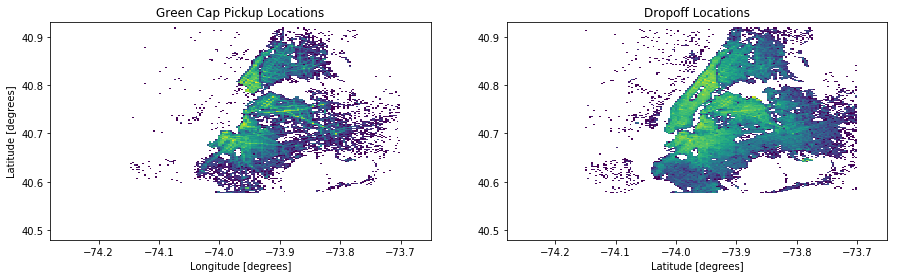

In [430]:
from matplotlib.colors import LogNorm
latmin = 40.48
lonmin = -74.28
latmax = 40.93
lonmax = -73.65
fig,ax = plt.subplots(1,2,figsize = (15,4))
ratio = np.cos(40.7 * np.pi/180) * (lonmax-lonmin) /(latmax-latmin)
fig = plt.figure(1, figsize=(8,ratio*8) )
hist = ax[0].hist2d(updated_green['Pickup_longitude'],updated_green['Pickup_latitude'],bins=199,range=[[lonmin,lonmax],[latmin,latmax]],norm=LogNorm())
ax[0].set_xlabel('Longitude [degrees]')
ax[0].set_ylabel('Latitude [degrees]')
ax[0].set_title('Green Cap Pickup Locations')
#plt.colorbar(label='Number',cax=ax[0])
#plt.show()

hist2 = ax[1].hist2d(updated_green['Dropoff_longitude'],updated_green['Dropoff_latitude'],bins=199,range=[[lonmin,lonmax],[latmin,latmax]],norm=LogNorm())
ax[1].set_xlabel('Longitude [degrees]')
ax[1].set_xlabel('Latitude [degrees]')
ax[1].set_title('Dropoff Locations')
#fig.colorbar(hist2,label='Number',ax=ax.ravel().tolist())
#ax.cax.colorbar(hist,label='Number')
plt.show()

## Modeling 

Since almost 60% of target feature are 0.0%, we'd better make 2 models. 
1. Binary classification model (tips = 1/ no tips = 0) 
2. Regression model (Predict tip percentage when tip percentage > 0 ) 

## Classification Model 

I will build a RandomForest classification model for binary classification because RandomForest model has the ability to handle a large data set with high dimensionality by providing high accuracy.  

### Hyper-parameter tuning 

I tried to optimize hyper-paramters (n_estimators, max_depth and min_samples_split) by using gridsearch with 3-fold cross-validation.


Selected hyper-parameters : ***{'min_samples_split': 10, 'n_estimators': 60, 'max_depth': 20}***

In [116]:
from sklearn.model_selection import cross_val_predict, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix


In [118]:
#I randomly selected 75% of data-set to use it as training data set and 25% of them as test data set.
train_ratio = 0.75
updated_green['is_train'] = np.random.uniform(0, 1, updated_green.shape[0]) <= train_ratio 
train_green = updated_green[updated_green['is_train']==1]
train_green = train_green.drop(columns = ['is_train'])

In [189]:
rf = RandomForestClassifier(n_jobs=-1,n_estimators=50, max_depth= 10, min_samples_split=10) 

param_grid = { 
    'n_estimators': [50,60],
    'max_depth' : [20,50,70],
    'min_samples_split' : [10,20]
}


#Make target feature as binary data.
Y = train_green[['tip_percentage']]
Y.loc[train_green['tip_percentage'] >0 ,'tip_percentage']=1
Y.loc[train_green['tip_percentage'] == 0 ,'tip_percentage']=0
Y = Y['tip_percentage']
X = train_green.drop(columns=['tip_percentage'])


/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [40]:
from sklearn import metrics 
CV_RF = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy',cv = 3)
CV_RF.fit(X, Y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60], 'min_samples_split': [10, 20], 'max_depth': [20, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [41]:
#Selected hyper-parameters 
print CV_RF.best_params_

{'min_samples_split': 10, 'n_estimators': 60, 'max_depth': 20}


We can also find that the training models are ***overfitted because the accuracies of training models are much higher than the accuracies of test models.*** .
<br>
So I will build another model with using less features to solve this problem.

In [42]:
#Cross Validation result by each hyper-parameter candidate
print CV_RF.cv_results_['mean_train_score']
print CV_RF.cv_results_['mean_test_score']

[0.94434962 0.94436135 0.94218079 0.94219477 0.96454354 0.96429199
 0.94987743 0.94972145 0.96440154 0.96426044 0.94979628 0.94979087]
[0.83354476 0.83391082 0.83170998 0.83313092 0.83255659 0.82791418
 0.83226717 0.8313322  0.83293347 0.8320012  0.83159908 0.83018715]


/anaconda3/envs/py2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


When we look at the feature importance, we can see that payment type 1,2, pickup/drop off locations and trip distance  are the most important features. 

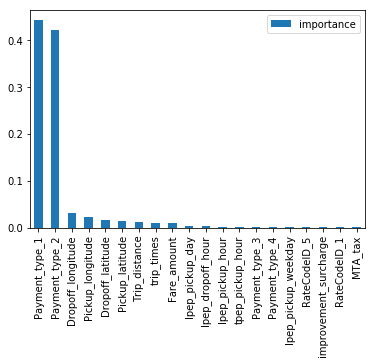

In [43]:
feature_importances = pd.DataFrame(CV_RF.best_estimator_.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head(20).plot.bar()

In [134]:
feature_importances['importance'].describe()

count    32.000000
mean      0.031250
std       0.105219
min       0.000000
25%       0.000425
50%       0.001505
75%       0.008858
max       0.441866
Name: importance, dtype: float64

I selected the following features whose importances are >= 75% percentile (0.008858) of feature importnace.
1. Payment_type_1
2. Payment_type_2
3. Dropoff_longitude
4. Pickup_longitude
5. Dropoff_latitude
6. Pickup_latitude
7. Trip_distance
8. trip_times
9. Fare_amount

In [50]:
top_features = feature_importances.reset_index().head(9)['index'].tolist()

Run GridSearch again with the selected features. 

Selected hyper-parameters : ***{'min_samples_split': 20, 'n_estimators': 60, 'max_depth': 70}***

In [190]:
CV_RF_2 = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='accuracy',cv = 3)
CV_RF_2.fit(X[top_features], Y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60], 'min_samples_split': [10, 20], 'max_depth': [20, 50, 70]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [191]:
print CV_RF_2.best_params_

{'min_samples_split': 20, 'n_estimators': 60, 'max_depth': 70}


We can see that the accuracies of test data set in CV are improved and the difference between accuracies of training and test data set decreased. 

1. Best hyper-parameter: **{'min_samples_split': 20, 'n_estimators': 60, 'max_depth': 70}**
2. Mean of train accuracy in 3 fold CV:  ***0.955*** 
3. Mean of test accuracy in 3 fold CV: ***0.936***
4. Standard deviation of accruacy of train in 3 fold CV: ***1.46334589e-04***
5. Standard deviation of accuracy of test in 3 fold CV: ***0.00091053***

In [192]:
print "**** mean of accuracy ****"
print "train: "+ str(CV_RF_2.cv_results_['mean_train_score'])
print "test: " + str(CV_RF_2.cv_results_['mean_test_score'])
print "**** STD of accuracy ****"
print "train: " + str(CV_RF_2.cv_results_['std_train_score'])
print "test: " + str(CV_RF_2.cv_results_['std_test_score'])
print "**** rank ****"
print CV_RF_2.cv_results_['rank_test_score']

**** mean of accuracy ****
train: [0.94863195 0.94859769 0.94501121 0.94498461 0.97061521 0.97051602
 0.95501368 0.9549181  0.97064631 0.9706941  0.95501638 0.95501909]
test: [0.93625848 0.93627652 0.93634144 0.93631799 0.9362152  0.93633693
 0.93636939 0.93637931 0.93609978 0.93618184 0.93638652 0.93648932]
**** STD of accuracy ****
train: [1.65140642e-04 2.70438917e-04 1.62807347e-04 3.50636005e-04
 1.28056984e-04 7.67440713e-05 1.43599306e-04 1.36274677e-04
 1.34187046e-04 3.78838195e-05 1.19363343e-04 1.46334589e-04]
test: [0.0011065  0.00100715 0.00098725 0.00100505 0.00072027 0.0007564
 0.00080152 0.00095792 0.00082986 0.00082735 0.00086757 0.00091053]
**** rank ****
[ 9  8  5  7 10  6  4  3 12 11  2  1]


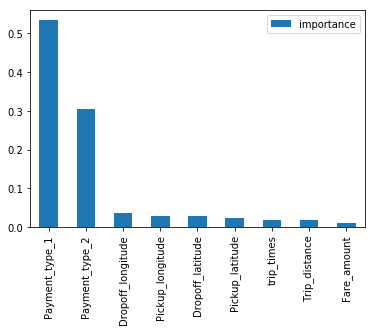

In [87]:
feature_importances_2 = pd.DataFrame(CV_RF_2.best_estimator_.feature_importances_,
                                   index = X[top_features].columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances_2.plot.bar()

### Test set 

Let's check the performance of the model with test data set.

In [193]:
test_green = updated_green[updated_green['is_train']==0]
test_green = test_green.drop(columns=['is_train'])

In [194]:
print test_green.shape
print train_green.shape

(369480, 33)
(1109026, 33)


In [195]:
Y_test = test_green[['tip_percentage']]
Y_test.loc[test_green['tip_percentage'] >0 ,'tip_percentage']=1
Y_test.loc[test_green['tip_percentage'] == 0 ,'tip_percentage']=0
Y_test = Y_test['tip_percentage']
X_test = test_green.drop(columns=['tip_percentage'])
X_test = X_test[top_features]

/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [196]:
Y_test_pred = CV_RF_2.best_estimator_.predict(X_test)

### Model evaluations 

I checked the model performance with test data-set

#### Confusion matrix

In [197]:
pd.crosstab(Y_test, Y_test_pred, rownames=['Actual'], colnames=['Predicted'])

Predicted,0.0,1.0
Actual,,
0.0,198708,21152
1.0,2069,147551


In [198]:
print "accuracy:", metrics.accuracy_score(Y_test_pred,Y_test)
print "roc_auc:", metrics.roc_auc_score(Y_test_pred,Y_test)
print "recall_score:", metrics.recall_score(Y_test_pred,Y_test)
print "precision_score:", metrics.precision_score(Y_test_pred,Y_test)

accuracy: 0.9371522139222691
roc_auc: 0.9321574644616593
recall_score: 0.8746198941334772
precision_score: 0.9861716348081807


### ROC CURVE 

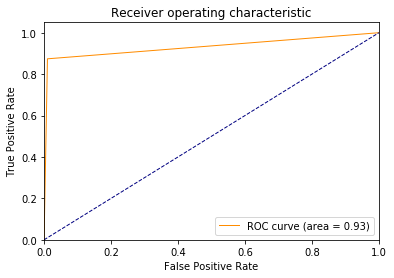

In [83]:
fpr, tpr, thresholds = roc_curve(Y_test_pred,Y_test)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

When we see the accuracy, roc_auc, recall_score, precision_score and ROC_curve, we can see that the performance classification model is decent.

## Regression Model 

In the case when tip_percentage > 0.0 %, I will use a regression model to predict tip_percentage.

In [199]:
train_ratio = 0.75
updated_green_1 = updated_green[updated_green['tip_percentage']>0] 
updated_green_1['is_train'] = np.random.uniform(0, 1, updated_green_1.shape[0]) <= train_ratio 
train_green_1 = updated_green_1[updated_green_1['is_train']==1]
test_green_1 = updated_green_1[updated_green_1['is_train']==0]

/anaconda3/envs/py2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [200]:
print train_green_1.shape
print test_green_1.shape

(449915, 34)
(149996, 34)


## Model Training 

### Hyper-parameter tuning 

I tried to optimize hyper-paramters (n_estimators, max_depth and min_samples_split) by using gridsearch with 3-fold cross-validation.

In [201]:
rf_reg = RandomForestRegressor(n_jobs=-1,n_estimators=50, max_depth= 10, min_samples_split=10) 

param_grid = { 
    'n_estimators': [50,60],
    'max_depth' : [10,20,50],
    'min_samples_split' : [10,20]
}


Y = train_green_1['tip_percentage']
X = train_green_1.drop(columns=['tip_percentage','is_train'])

In [202]:
CV_RF_REG_2 = GridSearchCV(estimator=rf_reg, param_grid=param_grid, scoring='neg_mean_squared_error',cv = 3)
CV_RF_REG_2.fit(X, Y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60], 'min_samples_split': [10, 20], 'max_depth': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [203]:
print CV_RF_REG_2.best_params_

{'min_samples_split': 20, 'n_estimators': 60, 'max_depth': 20}


#### GridSearhCV result 

1. Best hyper-parameter: **{'min_samples_split': 20, 'n_estimators': 60, 'max_depth': 10}**
2. Mean of train Mean Squared Error in 3 fold CV:  ***0.00229879*** 
3. Mean of test Mean Squared Error in 3 fold CV: ***0.00246324***
4. Standard deviation of mean squred errors of training data in 3 fold CV: ***1.88176747e-05***
5. Standard deviation of mean squred errors of test data in 3 fold CV: ***6.03115343e-05***

We can see that MSE of test and train are not really different. But I will also try to build a model with less features with high feature importances.

In [156]:
print "**** mean of accuracy ****"
print CV_RF_REG_2.cv_results_['mean_train_score']
print CV_RF_REG_2.cv_results_['mean_test_score']
print "**** sd of accuracy ****"
print str(CV_RF_REG_2.cv_results_['std_train_score'])
print str(CV_RF_REG_2.cv_results_['std_test_score'])
print "**** rank ****"
print CV_RF_REG_2.cv_results_['rank_test_score']

**** mean of accuracy ****
[-0.00227123 -0.00226802 -0.00229833 -0.00229879 -0.00170571 -0.00170108
 -0.00184323 -0.00184068 -0.00080139 -0.00079727 -0.00116108 -0.00115739]
[-0.00246396 -0.00246665 -0.00246466 -0.00246324 -0.00248612 -0.00248811
 -0.00247985 -0.00247893 -0.00250802 -0.00251096 -0.00250164 -0.00249858]
**** sd of accuracy ****
[1.75989901e-05 1.50826081e-05 1.98849593e-05 1.88176747e-05
 2.01748861e-05 1.85131543e-05 1.99334351e-05 1.88299141e-05
 7.60678769e-06 8.73355686e-06 8.99427089e-06 1.07399052e-05]
[6.26140863e-05 5.95072647e-05 5.45682846e-05 6.03115343e-05
 8.32778519e-05 9.41492779e-05 8.24981769e-05 8.46795758e-05
 8.08910967e-05 9.71058169e-05 1.02849052e-04 1.01329885e-04]
**** rank ****
[ 2  4  3  1  7  8  6  5 11 12 10  9]


In [204]:
feature_importances_REG = pd.DataFrame(CV_RF_REG_2.best_estimator_.feature_importances_,
                                   index = X.columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances_REG.head(20)

,importance
Fare_amount,0.487374
Dropoff_latitude,0.079837
Pickup_latitude,0.078618
Dropoff_longitude,0.071022
Pickup_longitude,0.062286
trip_times,0.055165
Trip_distance,0.050765
lpep_pickup_day,0.026054
improvement_surcharge,0.018658
lpep_dropoff_hour,0.012193


In [150]:
feature_importances_REG['importance'].describe()

count    34.000000
mean      0.029412
std       0.122381
min       0.000000
25%       0.000077
50%       0.002494
75%       0.005211
max       0.716706
Name: importance, dtype: float64

In [205]:
top_features_reg = feature_importances_REG.reset_index().head(10)['index'].tolist()

In [206]:
from sklearn.metrics import mean_squared_error

In [207]:
CV_RF_reg_2_1 = GridSearchCV(estimator = rf_reg, param_grid=param_grid, scoring='neg_mean_squared_error',cv = 3)
CV_RF_reg_2_1.fit(X[top_features_reg], Y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=10,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [50, 60], 'min_samples_split': [10, 20], 'max_depth': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [208]:
print CV_RF_reg_2_1.best_params_

{'min_samples_split': 20, 'n_estimators': 60, 'max_depth': 20}


#### GridSearchCV result 

1. Best hyper-parameter: **{'min_samples_split': 20, 'n_estimators': 50, 'max_depth': 10}**
2. Mean of train Mean Squared Error in 3 fold CV:  ***0.00230789*** 
3. Mean of test Mean Squared Error in 3 fold CV: ***0.00246292***
4. Standard deviation of mean squred errors of training data in 3 fold CV: ***1.86101962e-05***
5. Standard deviation of mean squred errors of test data in 3 fold CV: ***5.31945993e-05***

We can see the performance of the model is slightly better than the previous one. 

In [164]:
print "**** mean of accuracy ****"
print str(CV_RF_reg_2_1.cv_results_['mean_train_score'])
print str(CV_RF_reg_2_1.cv_results_['mean_test_score'])
print "**** STD of accuracy ****"
print str(CV_RF_reg_2_1.cv_results_['std_train_score'])
print str(CV_RF_reg_2_1.cv_results_['std_test_score'])
print "**** rank ****"
print CV_RF_reg_2_1.cv_results_['rank_test_score']

**** mean of accuracy ****
[-0.00227898 -0.00227765 -0.00230789 -0.00230719 -0.00173834 -0.00173831
 -0.00187503 -0.0018725  -0.00082859 -0.00082513 -0.00119187 -0.00118798]
[-0.00246897 -0.00246292 -0.00246255 -0.00246627 -0.0024888  -0.00247956
 -0.00248301 -0.00247702 -0.00253271 -0.0025181  -0.002505   -0.00250908]
**** STD of accuracy ****
[1.68005725e-05 1.65945313e-05 1.86101962e-05 1.85794109e-05
 1.83046477e-05 1.76208081e-05 1.90924129e-05 2.15471520e-05
 8.52238848e-06 8.21690966e-06 1.19843960e-05 1.19304143e-05]
[5.61074454e-05 5.07832711e-05 5.31945993e-05 5.32103959e-05
 8.27996736e-05 7.49641070e-05 7.88713475e-05 7.27213652e-05
 9.59766104e-05 8.47425636e-05 7.96931061e-05 9.09656549e-05]
**** rank ****
[ 4  2  1  3  8  6  7  5 12 11  9 10]


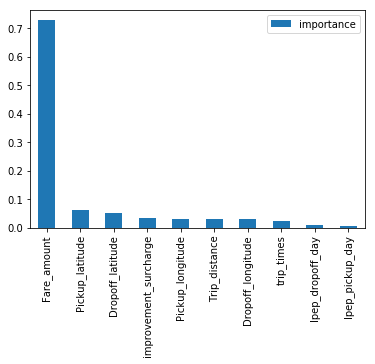

In [165]:
feature_importances_reg_2 = pd.DataFrame(CV_RF_reg_2_1.best_estimator_.feature_importances_,
                                   index = X[top_features_reg].columns,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances_reg_2.plot.bar()

## Test set 

Let's check the performance of the model with test-data set.

In [166]:
print test_green_1.shape
print train_green_1.shape

(149908, 36)
(450003, 36)


In [167]:
Y_test_reg = test_green_1['tip_percentage']
X_test_reg = test_green_1.drop(columns=['tip_percentage','is_train'])

## Model evaluation 

I checked the performance of a regression model with the following metrics.
1. MSE (mean squared error) 
2. MAP  (mean ablosute error)
3. R squared

In [168]:
Y_test_reg_pred = CV_RF_reg_2_1.best_estimator_.predict(X_test_reg[top_features_reg])

In [169]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
print "MSE: " + str(mean_squared_error(Y_test_reg, Y_test_reg_pred)) 
print "MAE: " + str(mean_absolute_error(Y_test_reg, Y_test_reg_pred))
print "R2: " + str(r2_score(Y_test_reg, Y_test_reg_pred))

MSE: 0.002500022140814859
MAP: 0.03156320460206166
R2: 0.24447052606960895


In [170]:
Y_test_reg.describe()

count    149908.000000
mean          0.164428
std           0.057524
min           0.000083
25%           0.159744
50%           0.166667
75%           0.166707
max           1.000000
Name: tip_percentage, dtype: float64

## Final model 

Final model should have the following process.

1. Predict whether a passenger pay tip or not by using a binary classification model (tips = 1/ no tips = 0). 
2. For the test set whose predicted value from step 1 is **1**, estimate tip percentage by using a regression model (Predict tip percentage when tip percentage > 0 ).  
3. Check the performance of result with using mean squared error, mean absolute error and R-squared. 


In [184]:
def model_fit(classfication_model, regression_model, test_input, target_name,top_features, top_features_reg):
    
    #get classification prediction result
    test_input_feature_class = test_input.drop(columns=[target_name])    
    Y_test_class_pred = classfication_model.best_estimator_.predict(test_input_feature_class[top_features])
   
    #Extract the training data when pred = 1
    test_input_reg = test_input[Y_test_class_pred == 1]
    
    #actual value of target feature which is predicted as 0 
    Y_act_class = test_input[Y_test_class_pred == 0][target_name]
    Y_pred_class =Y_test_class_pred[Y_test_class_pred == 0]
    
    output1 = {"Y_act": Y_act_class, "Y_pred":Y_pred_class}
    classification_output = pd.DataFrame(data = output1)
    
    Y_act_reg = test_input_reg[target_name]
    test_input_feature_reg = test_input_reg.drop(columns=[target_name])  
    
    Y_test_reg_pred = regression_model.best_estimator_.predict(test_input_feature_reg[top_features_reg])
    print Y_test_reg_pred
    output2 = {"Y_act": Y_act_reg, "Y_pred":Y_test_reg_pred}    
    reg_output = pd.DataFrame(data = output2)
    
    final_output = pd.concat([classification_output,reg_output],ignore_index=True)
    
    return final_output
    
    

In [209]:
fianl_output = model_fit(CV_RF_2, CV_RF_reg_2_1, test_green,'tip_percentage' ,top_features, top_features_reg)

[0.21273526 0.17324298 0.17588869 ... 0.17199927 0.16073712 0.1734616 ]


In [210]:
print "MSE: " + str(mean_squared_error(fianl_output['Y_act'], fianl_output['Y_pred'])) 
print "MAP: " + str(mean_absolute_error(fianl_output['Y_act'], fianl_output['Y_pred']))
print "R2: " + str(r2_score(fianl_output['Y_act'], fianl_output['Y_pred']))

MSE: 0.002577996383330058
MAP: 0.02202952220835794
R2: 0.6699831892230544


When we check the MSE, MAP and R-squared, I think the performance of predictive model could be improved with some future works.

## Future works 

If I have more time I will work on following things to improve the performance of the model.
1. **Feature Extraction and Selection** : I will try to spend more time for data analysis of input features and try to derive and select features to improve the performance of the model
2. **Hyper-parameter Tunning** : I will try more hyper-parameter to imporve the model performance.
3. **Build additional models** : I will try to build addtional ML models and compare the performances of them 

